In [1]:
# 定义一个 ResNetGenerator 类
import torch
import torch.nn as nn

class ResNetBlock(nn.Module): # <1>

    def __init__(self, dim):
        super(ResNetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim)

    def build_conv_block(self, dim):
        conv_block = []

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim),
                       nn.ReLU(True)]

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x) # <2>
        return out


class ResNetGenerator(nn.Module):

    def __init__(self, input_nc=3, output_nc=3, ngf=64, n_blocks=9): # <3> 

        assert(n_blocks >= 0)
        super(ResNetGenerator, self).__init__()

        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=True),
                 nn.InstanceNorm2d(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3,
                                stride=2, padding=1, bias=True),
                      nn.InstanceNorm2d(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [ResNetBlock(ngf * mult)]

        for i in range(n_downsampling):
            mult = 2**(n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=True),
                      nn.InstanceNorm2d(int(ngf * mult / 2)),
                      nn.ReLU(True)]

        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input): # <3>
        return self.model(input)

In [2]:
netG = ResNetGenerator()

现在 netG 模型已经创建，但它包含的是随机权重。我们之前提到过将运行一个在将马转换为斑马的数据集上预先训练过的生成器模型，它的训练集包括 2 个集合，分别为 1068 张马的照片和 1335 张斑马的照片。该数据集可以在异步社区本书代码地址中找到。模型的权重保存在一个扩展名为“pth”的文件中，该文件只是一个模型张量参数的 pickle 文件。我们可以使用模型的 load_state_dict()方法将权重加载到 ResNetGenerator 中。

In [3]:
model_path = '../data/p1ch2/horse2zebra_0.4.0.pth'
model_data = torch.load(model_path)
netG.load_state_dict(model_data)

<All keys matched successfully>

至此， netG 对象已经获得了它在训练中需要获得的所有知识。注意，这与我们在 2.1.3 小节提到的从 TorchVision 模块加载 resnet101 完全相同，但 torchvision.resnet101()方法的加载过程对我们是透明的。

In [4]:
netG.eval()

ResNetGenerator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResNetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
     

我们准备加载一匹马的随机图像，看看我们的生成器会生成什么。首先我们需要导入 PIL 和TorchVision 模块。

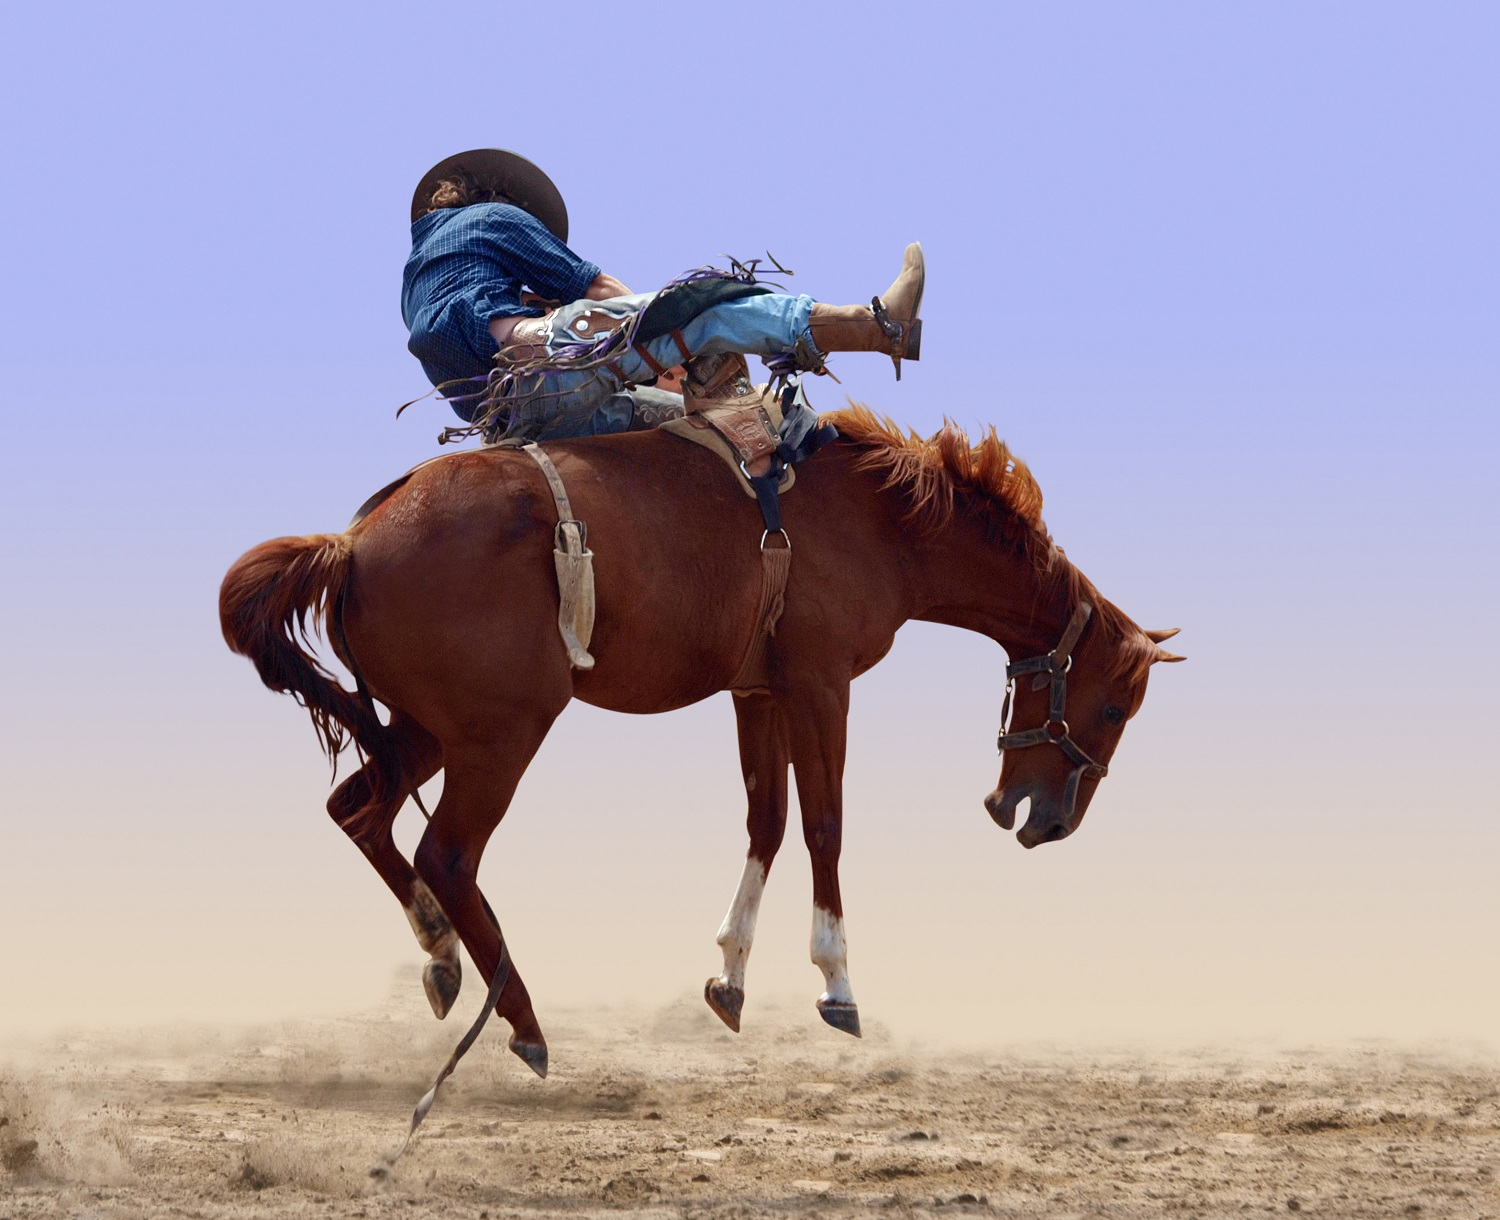

In [5]:
from PIL import Image
from torchvision import transforms
# 定义一些输入变换，确保数据以正确的形状和大小进入网络
preprocess = transforms.Compose([transforms.Resize(256),
                                 transforms.ToTensor()])
# 打开一个马的图像文件
img = Image.open('../data/p1ch2/horse.jpg')
img

通过预处理，将其转化为一个合适的形状变量

In [8]:
img_t = preprocess(img)
batch_t = torch.unsqueeze(img_t, 0)

将 batch_t 变量传递给我们的模型

In [10]:
batch_out = netG(batch_t)

batch_out 变量现在表示生成器的输出，我们可以将它转换为图像
1. `batch_out.data.squeeze()`: squeeze()函数的作用是去掉张量中长度为1的维度。在这里，它被用来将输出张量的形状从(1, C, H, W)变为(C, H, W)，其中C、H和W分别代表通道数、高度和宽度。

2. `+1.0`: 这个操作是为了将数据范围从[-1, 1]变为[0, 2]。这是因为在训练神经网络时，通常会将输入图片的像素值从[0, 255]归一化到[-1, 1]，所以在将输出转换回图片时，需要进行反向操作。

3. `/ 2.0`: 这个操作是为了将数据范围从[0, 2]变为[0, 1]。这是因为在将张量转换为PIL图像时，需要的输入范围是[0, 1]。

所以，这行代码的主要作用是将神经网络的输出进行适当的变换，使其可以被转换为PIL图像。

`data`是`torch.Tensor`对象的一个属性，它返回与当前张量（tensor）相同数据的新张量。这个新张量和原始张量共享相同的内存，但不会共享历史记录，也就是说，它不会保存计算图的信息，因此不能进行梯度反向传播。

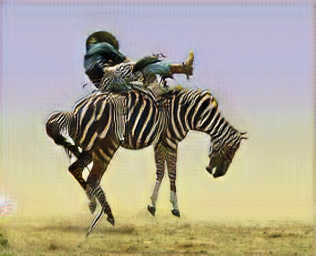

In [11]:
out_t = (batch_out.data.squeeze() + 1.0) / 2.0
out_img = transforms.ToPILImage()(out_t)
out_img